In [1]:
%pylab
%matplotlib inline
rc('text', usetex = True)

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
import pyfits as fits
from astropy.utils.data import download_file
import pandas as pd
from lmfit import Parameters, minimize
from numpy.linalg import lstsq, solve

In [3]:
### Download data


### Cepheid table
cepheid_table = download_file(
        'http://iopscience.iop.org/0004-637X/730/2/119/suppdata/apj383673t2_mrt.txt', 
        cache = True)
cepheids = pd.read_csv(cepheid_table,
                       delim_whitespace = True,
                       skiprows = 39,
                       names = (['Field', 'RAdeg', 
                                 'DEdeg', 'ID', 
                                 'Period', 'VtoI', 
                                 'F160Wmag', 'e_F160Wmag',
                                 'Offset', 'Bias', 
                                 'IMrms', 'ObyH', 'Flag']
                               )
                      )

cepheids=cepheids.fillna(value = '-')
### SNe table
Sne_table = download_file(
        'http://iopscience.iop.org/0004-637X/730/2/119/suppdata/apj383673t3_ascii.txt',
        cache = True)
Sne = pd.read_csv(Sne_table, 
                   
                  delim_whitespace=True, 
                  skiprows = [0,1,2,3,4,13,15],
                  names = (['Host', 'junk','Sn1A',
                            'Filters', 'm0_viPlus5a_v',
                            'sigma', 'DeltaMu_0','e_DeltaMu_0',
                            'mu_0_Best', 'e_mu_0_Best'
                          ])
                 )
Sne.loc[:,'e_DeltaMu_0'] = (Sne.loc[:,'e_DeltaMu_0'].apply(str).str.replace('\(|\)','')).astype('float')
Sne.loc[:,'e_mu_0_Best'] = (Sne.loc[:,'e_mu_0_Best'].apply(str).str.replace('\(|\)','')).astype('float')


maser_distance = {'mu':7.2, 'e_mu':0.32} 
maser_distance = pd.DataFrame(data = maser_distance, index = arange(1))

In [4]:
print ' %3.0f total cepheids \n %3.0f rejected \n %3.0f low P \n %3.0f low P and rejected'%(cepheids.shape[0], 
       cepheids.loc[cepheids.Flag == 'rej',:].shape[0], 
       cepheids.loc[cepheids.Flag == 'low',:].shape[0], 
       cepheids.loc[cepheids.Flag == 'rej,low',:].shape[0])
print '----------'
print ' %3.0f kept'%(cepheids.shape[0]-
       cepheids.loc[cepheids.Flag == 'rej',:].shape[0]- 
       #cepheids.loc[cepheids.Flag == 'low',:].shape[0]-
       cepheids.loc[cepheids.Flag == 'rej,low',:].shape[0])

 647 total cepheids 
 126 rejected 
  53 low P 
  24 low P and rejected
----------
 497 kept


In [27]:
print set(cepheids.Flag)
cepheids = cepheids.loc[cepheids.Flag != 'rej',:]
cepheids = cepheids.loc[cepheids.Flag != 'rej,low',:]
cepheids = cepheids.loc[cepheids.Flag != 'low',:]
print set(cepheids.Flag)

cepheids = cepheids.reset_index(drop = True)
y = cepheids.F160Wmag - 0.410 * cepheids.VtoI 
y = list(y)
numcephs =  len(y)
y += list(Sne.m0_viPlus5a_v- 0.698 * 5)
y = array(y)


yerr = (cepheids.e_F160Wmag).tolist()
yerr += Sne.sigma.tolist()
yerr = array(yerr)
Cinv = diag(1.0/yerr**2)
print Cinv

set(['rej', 'rej,low', '-', 'low'])
set(['-'])
[[ 10.40582726   0.           0.         ...,   0.           0.           0.        ]
 [  0.           5.66893424   0.         ...,   0.           0.           0.        ]
 [  0.           0.           5.16528926 ...,   0.           0.           0.        ]
 ..., 
 [  0.           0.           0.         ...,  94.25959091   0.           0.        ]
 [  0.           0.           0.         ...,   0.          67.18624026
    0.        ]
 [  0.           0.           0.         ...,   0.           0.          53.2793436 ]]


In [6]:
set(cepheids.Field)
print numcephs

647


In [7]:
def subtractmean(cephieds):
    for field in set(cepheids.Field):
        print field, mean(cepheids.loc[cepheids.Field == field, 'ObyH'])
        cepheids.loc[cepheids.Field == field,'ObyH'] += -mean(cepheids.loc[cepheids.Field == field, 'ObyH'])
        print field, mean(cepheids.loc[cepheids.Field == field, 'ObyH'])

    return cepheids

In [8]:
paramnames = []
#cepheids = subtractmean(cepheids)
fields = list(set(cepheids.Field))
fields.remove('n4258')
L = zeros([y.size, 12])
L[:numcephs,-4] = log10(cepheids.Period) ## PL-period slope
L[:numcephs,-3] = cepheids.ObyH - 8.9## PL-metallicity slope
L[:numcephs, -2] = 1 ## PL-intercept
L[numcephs:,-1] = 1 ## M^0_4258
for i, field in enumerate(fields):
    if field != 'n4258':
        cephindex = cepheids.loc[cepheids.Field == field, :].index.tolist()
        L[cephindex,i] = 1
        snindex = Sne.loc[Sne.Host == field,:].index.tolist()
        snindex = [x + numcephs for x in snindex]
        L[snindex,i] = 1
        paramnames.append(field)
paramnames.append('Per')
paramnames.append('Met')
paramnames.append('Int')
paramnames.append('M^0')
Lframe = pd.DataFrame(L)
Lframe.columns = paramnames

In [9]:
L[-2,:]

array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.])

In [10]:
param_cinv = (dot(L.T, dot(Cinv, L)))

In [11]:
LtCinv = dot(L.T, Cinv)
LtCinvY = dot(LtCinv, y)

In [12]:
bestfit = solve(param_cinv, LtCinvY)

In [13]:
bestfit

array([  2.63538768,   1.46339041,   2.1431222 ,   2.25669257,
         2.27450771,   2.11280032,   2.86125169,   3.06642505,
        -2.82718896,  -0.29305262,  26.0628692 ,  10.32756553])

In [14]:
error = diag(inv(param_cinv))
#error = (1/diag(param_cinv))
error = sqrt(error)

In [15]:
print paramnames

['n3370', 'n4536', 'n3982', 'n5584', 'n4639', 'n4038', 'n3021', 'n1309', 'Per', 'Met', 'Int', 'M^0']


In [16]:
 zip(paramnames, zip(bestfit, error))
params = dict(zip(paramnames,zip(bestfit, error)))
params

{'Int': (26.062869195597486, 0.067178661903889242),
 'M^0': (10.327565528276221, 0.047909170149893682),
 'Met': (-0.29305262051282027, 0.0764038251878459),
 'Per': (-2.8271889552675376, 0.041836796322680579),
 'n1309': (3.0664250511919753, 0.042226074202516832),
 'n3021': (2.8612516947519486, 0.066899844117372889),
 'n3370': (2.6353876755870318, 0.03604043699685288),
 'n3982': (2.1431222037268269, 0.048372000107146963),
 'n4038': (2.1128003201535459, 0.057471261344172478),
 'n4536': (1.4633904102067377, 0.034424373946360456),
 'n4639': (2.2745077097978799, 0.048227879162976009),
 'n5584': (2.2566925719258699, 0.034397327608215053)}

In [17]:
m04258 = [bestfit[-1], error[-1]]
a_nu = [0.698, 0.00225]
mu_geometric = [7.60, 0.32]
H_0 = [10**((5 * a_nu[0] + 25  + m04258[0] - 5*log10(mu_geometric[0])-25)/5.0)]
H_0.append(H_0[0]*
         sqrt(
        (a_nu[1] * log(10))**2 
        + (log(10)/5 * m04258[1])**2
        + (mu_geometric[1]/mu_geometric[0])**2             
    )     )

In [18]:
print H_0

[76.330747142517993, 3.6499105320332919]


In [19]:
H_0[1]/0.023

158.69176226231704

In [20]:
ceph4258 = cepheids.loc[cepheids.Field == 'n4258',:]

In [21]:
weights = ceph4258.e_F160Wmag/sum(ceph4258.e_F160Wmag)
sum(ceph4258.F160Wmag*weights)

24.054551042545501

In [22]:
for field in set(cepheids.Field):
    print field, cepheids.loc[cepheids.Field == field, :].shape[0]

n3370 101
n4536 69
n3982 38
n5584 103
n4639 37
n4038 46
n4258 167
n3021 30
n1309 56


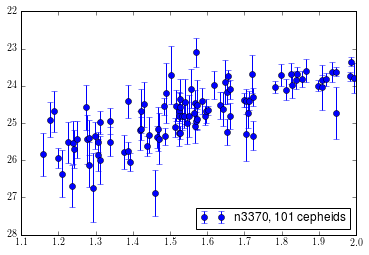

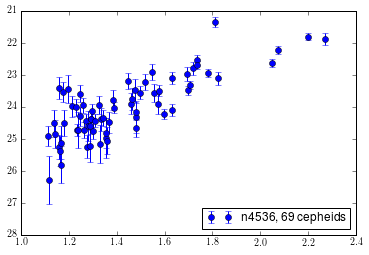

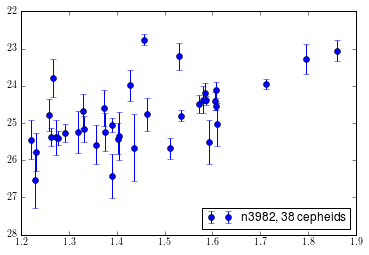

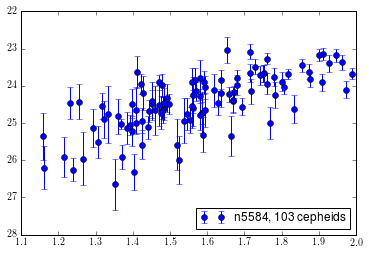

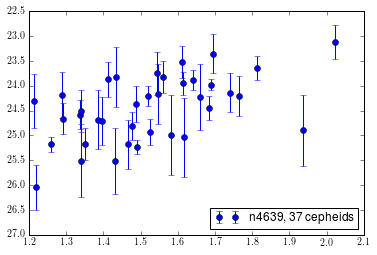

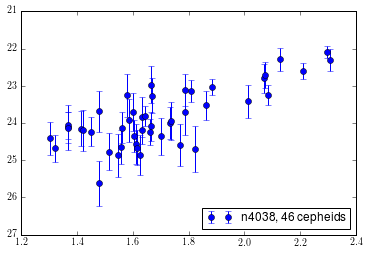

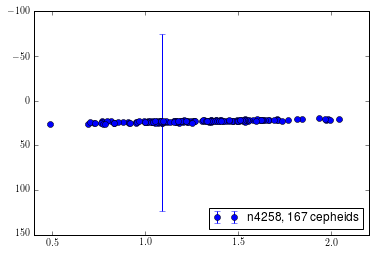

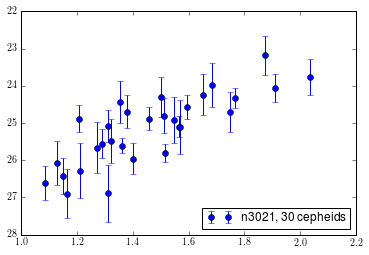

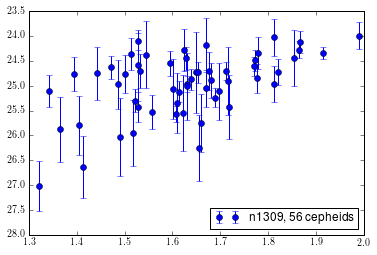

In [23]:
#b = params['Per'][0]
#Z = params['Met'][0]
#Int = params['Int'][0]
#int = bestfit[-1]
cephcounts = {}
for field in set(cepheids.Field):
    figure()
    errorbar(log10(cepheids.loc[cepheids.Field == field, 'Period'].tolist()),
            cepheids.loc[cepheids.Field == field, 'F160Wmag'].tolist(),
            yerr = cepheids.loc[cepheids.Field == field, 'e_F160Wmag'].tolist(),
            fmt = 'o',
            label = '%s, %3.0f cepheids'%(field, len(cepheids.loc[cepheids.Field == field, 'F160Wmag'].tolist())))
    cephcounts[field] = len(cepheids.loc[cepheids.Field == field, 'F160Wmag'].tolist())
    legend(loc = 4)
    gca().invert_yaxis()

In [24]:
cephcounts
print 43 + 25 + 86+ 29+35+120+49+29+94
r11counts = {'n1309':43, 'n3021':25, 'n3370':86, 'n3982':29, 'n4038':35, 'n4258':120, 'n4536':49, 'n4639':29, 'n5584':94}
for key in cephcounts.keys():
    print key, cephcounts[key] - r11counts[key]

510
n3370 15
n4536 20
n3021 5
n5584 9
n4639 8
n4038 11
n4258 47
n3982 9
n1309 13


In [25]:
cepheids

,Field,RAdeg,DEdeg,ID,Period,VtoI,F160Wmag,e_F160Wmag,Offset,Bias,IMrms,ObyH,Flag
0,n4536,188.590,2.16830,27185.0,13.000,0.97,24.91,0.31,1.64,0.13,2.16,8.54,-
1,n4536,188.604,2.18312,42353.0,13.070,0.73,26.29,0.74,3.32,0.37,4.30,8.97,rej
2,n4536,188.584,2.18070,50718.0,13.730,0.88,24.51,0.42,0.88,0.28,11.40,8.64,-
3,n4536,188.583,2.19700,72331.0,13.910,0.89,24.84,0.44,0.07,0.22,1.40,8.81,-
4,n4536,188.590,2.19545,65694.0,14.380,0.98,25.26,0.38,2.91,0.39,30.80,8.90,-
5,n4536,188.587,2.18864,58805.0,14.440,1.13,23.41,0.35,3.94,0.26,47.90,8.78,rej
6,n4536,188.586,2.18406,53703.0,14.530,0.72,25.38,0.47,0.63,0.27,14.90,8.72,-
7,n4536,188.592,2.20025,70938.0,14.620,0.64,25.81,0.58,2.39,0.30,17.40,8.94,rej
8,n4536,188.594,2.17693,40098.0,14.640,0.95,25.12,0.52,4.40,0.63,12.90,8.72,-
9,n4536,188.597,2.18489,48539.0,15.030,0.90,23.53,0.31,0.46,0.29,7.28,8.89,rej


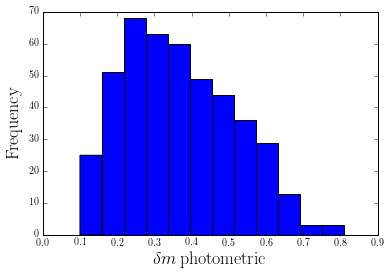

In [37]:
hist(cepheids.e_F160Wmag, bins = 12);
ylabel(r'${\rm Frequency}$', fontsize = 18);
xlabel(r'$\delta m{\rm \, photometric}$', fontsize = 18);